### Setup and Import

In [13]:
# 1. Setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set some nice visual defaults
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)




### Load the data
We import the **CSV** data fetched using our scrapers.

In [14]:
# 2. Load CSV
clubs = pd.read_csv("../Scrapping/Data/Clubs/club_stats.csv")
clubs.head() #display the first 5 rows


,club_id,name,league,league_id,country,rating,attack_rating,midfield_rating,defense_rating,stadium,...,manager_url,club_worth,starting_xi_avg_age,whole_team_avg_age,rival_team,players_count,top_players,club_logo,country_flag,url
0,9,Liverpool,Premier League,13,England,85,85,85,84,Anfield,...,https://sofifa.com/coach/23180/arne-slot/,€4.7B,26.45,24.64,Manchester United,28,"83 H. Ekitiké, 88 A. Isak, 83 D. Szoboszlai, 8...",https://cdn.sofifa.net/meta/team/8/120.png,https://cdn.sofifa.net/flags/gb-eng.png,https://sofifa.com/team/9/liverpool/
1,241,FC Barcelona,La Liga,53,Spain,85,85,85,83,El Libertador,...,https://sofifa.com/coach/37352367/hans-dieter-...,€4.9B,25.82,23.43,Real Madrid,28,"88 R. Lewandowski, 83 Ferran Torres, 85 Dani O...",https://cdn.sofifa.net/meta/team/83/120.png,https://cdn.sofifa.net/flags/es.png,https://sofifa.com/team/241/fc-barcelona/
2,243,Real Madrid,La Liga,53,Spain,85,88,86,83,Estadio Santiago Bernabéu,...,https://sofifa.com/coach/511/xabier-alonso-olano/,€5.8B,25.27,24.00,FC Barcelona,30,"91 K. Mbappé, 85 Rodrygo, 77 Endrick, 69 Gonza...",https://cdn.sofifa.net/meta/team/3468/120.png,https://cdn.sofifa.net/flags/es.png,https://sofifa.com/team/243/real-madrid/
3,1,Arsenal,Premier League,13,England,84,86,84,83,Emirates Stadium,...,https://sofifa.com/coach/307/mikel-arteta-amat...,€2.5B,25.91,25.42,Tottenham Hotspur,24,"83 L. Trossard, 83 E. Eze, 81 Gabriel Martinel...",https://cdn.sofifa.net/meta/team/19/120.png,https://cdn.sofifa.net/flags/gb-eng.png,https://sofifa.com/team/1/arsenal/
4,10,Manchester City,Premier League,13,England,84,82,85,82,Etihad Stadium,...,https://sofifa.com/coach/455361/josep-guardiol...,€4.6B,24.91,25.58,Manchester United,26,"80 J. Doku, 90 E. Haaland, 84 O. Marmoush, 74 ...",https://cdn.sofifa.net/meta/team/9/120.png,https://cdn.sofifa.net/flags/gb-eng.png,https://sofifa.com/team/10/manchester-city/


In [15]:
# 🛠 Fix numeric club names (India bug) BEFORE dropping URL columns
import re

# Known numeric ID corrections (club_id -> proper name) based on domain knowledge
KNOWN_NUMERIC_NAME_PATCHES = {
    # United Tigers SC appears as numeric-only name in the scraped export
    # if we've identified its club_id, patch by id; else fallback to URL slug
}

def recover_name_from_url(url: str) -> str | None:
    if not isinstance(url, str):
        return None
    m = re.search(r"/team/\d+/([^/]+)/?", url)
    if m:
        slug = m.group(1)
        # turn slug like "mohun-bagan" → "Mohun Bagan"
        return re.sub(r"[-_]+", " ", slug).title()
    return None

# First, if we know an explicit patch by club_id apply it
if "club_id" in clubs.columns and "name" in clubs.columns:
    patched = 0
    for cid, fixed_name in KNOWN_NUMERIC_NAME_PATCHES.items():
        mask = clubs["club_id"].eq(cid) & clubs["name"].astype(str).str.fullmatch(r"\d+")
        if mask.any():
            clubs.loc[mask, "name"] = fixed_name
            patched += int(mask.sum())
    if patched:
        print(f"✔ Applied {patched} explicit numeric-name patches by club_id.")

# Then, fallback: derive name from URL slug when 'name' is all digits
mask_numeric = clubs["name"].astype(str).str.fullmatch(r"\d+")
if mask_numeric.any():
    print(f"Repairing {mask_numeric.sum()} numeric club names using URL slugs...")
    repaired = clubs.loc[mask_numeric, "url"].apply(recover_name_from_url)
    # Specific known case: 132681 → United Tigers SC (if still not recovered properly)
    if "club_id" in clubs.columns:
        mask_ut = clubs["club_id"].eq(132681) & mask_numeric
        if mask_ut.any():
            clubs.loc[mask_ut, "name"] = "United Tigers SC"
            repaired.loc[mask_ut] = "United Tigers SC"
    clubs.loc[mask_numeric, "name"] = clubs.loc[mask_numeric, "name"].mask(repaired.notna(), repaired)
else:
    print("No numeric-only club names detected.")

Repairing 1 numeric club names using URL slugs...


- Each row: one football club
- Columns: attributes scraped (e.g., `rating`, `league`, `manager`, `country`, ...)

### Cleaning and preparing data
In this section, we remove **unused columns** and clean **text/numeric** fields to make them analysis-ready.

#### Remove unused columns, strip text, and convert numeric values

In [16]:
# 🧹 3. Clean / Prepare
clubs.info()

# --- 1. Strip whitespace--
text_cols = ["name", "league", "country", "stadium", "manager", "rival_team"]
clubs[text_cols] = clubs[text_cols].apply(lambda col: col.str.strip())

# turn billions and millions into numeric value 10m -> 10


def parse_club_worth(value):
    if isinstance(value, str):
        v = value.replace("€", "").replace(",", "").strip().upper()
        try:
            if "B" in v:
                return float(v.replace("B", "")) * 1000      # billions → millions
            elif "M" in v:
                return float(v.replace("M", ""))             # millions
            elif "K" in v:
                return float(v.replace("K", "")) / 1000      # thousands → millions
            elif v != "":
                return float(v) / 1_000_000                  # raw number → millions
        except ValueError:
            return np.nan
    return np.nan



clubs["club_worth_million"] = clubs["club_worth"].apply(parse_club_worth)


# --- 3. Check missing managers ---
print("Missing managers:", clubs["manager"].isna().sum())

# --- 4. Drop useless URL columns for now ---
clubs = clubs.drop(columns=["club_logo", "country_flag", "manager_url", "url"])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662 entries, 0 to 661
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   club_id              662 non-null    int64  
 1   name                 662 non-null    object 
 2   league               662 non-null    object 
 3   league_id            662 non-null    int64  
 4   country              662 non-null    object 
 5   rating               662 non-null    int64  
 6   attack_rating        662 non-null    int64  
 7   midfield_rating      662 non-null    int64  
 8   defense_rating       662 non-null    int64  
 9   stadium              662 non-null    object 
 10  manager              634 non-null    object 
 11  manager_id           634 non-null    float64
 12  manager_url          634 non-null    object 
 13  club_worth           662 non-null    object 
 14  starting_xi_avg_age  662 non-null    float64
 15  whole_team_avg_age   662 non-null    flo

We cleaned and standardized the dataset to make it ready for analysis:

- **Removed** extra spaces in text columns (e.g., `league`, `country`, `manager`).
- **Converted** `club_worth` from strings like "€4.7B" or "€850M" into a numeric column `club_worth_million` (values in millions).
- **Dropped** unused URL/image columns to simplify the data (`club_logo`, `country_flag`, `manager_url`, `url`).
- **Left** missing managers as `NaN` since they don’t affect numeric analysis.

#### Standardize league names
We unify naming and fix minor errors (e.g., **"Liga 1" → "Liga I"**).

In [5]:
# 📊 Display all unique league names sorted alphabetically
unique_leagues = sorted(clubs["league"].dropna().unique())

print(f"Total unique leagues: {len(unique_leagues)}\n")
for league in unique_leagues:
    print(league)


Total unique leagues: 42

1. Division
2. Bundesliga
3. Liga
A-League Men
Allsvenskan
Bundesliga
Categoría Primera A
Championship
División Profesional
División de Fútbol Profesional
Ekstraklasa
Eliteserien
Eredivisie
Hrvatska nogometna liga
K League 1
La Liga
La Liga 2
League One
League Two
Liga 1
Liga I
Liga Profesional de Fútbol
Ligue 1
Ligue 2
Major League Soccer
Nemzeti Bajnokság I
Premier Division
Premier League
Premiership
Premyer Liqa
Primeira Liga
Primera Division
Primera División
Pro League
První liga
Serie A
Serie B
Super League
Superliga
Série A
Süper Lig
Veikkausliiga


In [17]:
# ⚙️ Standardize league names
league_replacements = {
    # Spanish / Latin American
    "Primera Division": "Primera División",
    "División Profesional": "División de Fútbol Profesional",
    "Categoría Primera A": "Primera División",
    "Liga Profesional de Fútbol": "Primera División",

    # French
    "Ligue 1": "Ligue 1 Uber Eats",
    "Ligue 2": "Ligue 2 BKT",

    # Italian / Brazilian
    "Serie A": "Serie A",
    "Série A": "Serie A",      # unify accent variant
    "Serie B": "Serie B",

    # English
    "Premier League": "Premier League",
    "Championship": "EFL Championship",
    "League One": "EFL League One",
    "League Two": "EFL League Two",

    # Other European
    "Bundesliga": "Bundesliga",
    "Liga 1": "Liga I",       # unify Romania
    "Liga I": "Liga I",
    # DO NOT map generic 'Pro League' unconditionally — handled country-specific below
    # "Pro League": "Belgian Pro League",
    # Note: do NOT map generic 'Super League' → 'Swiss Super League' (avoids mixing Super Cups / other comps)
    "Süper Lig": "Turkish Süper Lig",
    "První liga": "Czech First League",

    "Premier Division": "Irish Premier Division",
    "Premiership": "Scottish Premiership",
    "1. Division": "Cypriot First Division",
    "Liga": "Liga (Generic)"
}

clubs["league"] = clubs["league"].replace(league_replacements)
print("Unique league names after cleaning:\n")
print(sorted(clubs["league"].unique()))

Unique league names after cleaning:

['2. Bundesliga', '3. Liga', 'A-League Men', 'Allsvenskan', 'Bundesliga', 'Cypriot First Division', 'Czech First League', 'División de Fútbol Profesional', 'EFL Championship', 'EFL League One', 'EFL League Two', 'Ekstraklasa', 'Eliteserien', 'Eredivisie', 'Hrvatska nogometna liga', 'Irish Premier Division', 'K League 1', 'La Liga', 'La Liga 2', 'Liga I', 'Ligue 1 Uber Eats', 'Ligue 2 BKT', 'Major League Soccer', 'Nemzeti Bajnokság I', 'Premier League', 'Premyer Liqa', 'Primeira Liga', 'Primera División', 'Pro League', 'Scottish Premiership', 'Serie A', 'Serie B', 'Super League', 'Superliga', 'Turkish Süper Lig', 'Veikkausliiga']


### 🧭 Analysis: League Performance Efficiency (Adjusted for Wealth)

In this section, we compare football leagues based on how efficiently they **convert financial resources into on-field performance**.

#### ⚙️ Methodology
- For each league, we compute:
  - **Average Club Rating** (`rating`) → overall sporting performance.
  - **Average Club Worth (€M)** (`club_worth_million`) → financial strength.
- Instead of a direct ratio (`rating / worth`), we use a **logarithmic adjustment**:

$$
\text{Efficiency}
= \frac{\text{Average Rating}}{\ln\!\big(1 + \text{Average Club Worth (M€)}\big)}
$$
We use **log(1 + x)** to:
- avoid undefined values when wealth = 0,

- stabilize the scale for small clubs,

preserve fairness across different magnitudes.
**Why log(1 + worth)?**
- **Diminishing returns:** spending more brings smaller relative gains; log compresses very large budgets.
- **Comparability:** narrows huge wealth gaps across leagues, making “performance per unit of financial power” more comparable.

#### 🎨 Visualization
- **Bar = league**
- **x-axis = adjusted efficiency score**
- **Color scale:** warmer colors (reds/yellows) → higher efficiency; cooler colors (blues) → lower efficiency.

#### 🧠 Interpretation
- **High-efficiency leagues** (e.g., Irish Premier Division, lower English divisions) show strong performance relative to modest budgets — they *punch above their weight*.
- **Low-efficiency leagues** (e.g., top European leagues) are strong in absolute performance, but very high club values reduce the efficiency score.
- Log scaling helps evaluate leagues **fairly across economic contexts**, avoiding excessive penalization of smaller markets.

#### 📊 Insights
- Captures **economic sustainability in performance** — doing more with less.
- Helps surface **overachieving leagues or undervalued markets**.

#### 💡 Key Takeaways
- Smaller/developing leagues often show **high efficiency**.
- Wealthier leagues dominate in absolute performance but not necessarily in efficiency.
- Highlights the trade-off between **spending power** and **return on performance**.

C:\Users\job\AppData\Local\Temp\ipykernel_23040\2358241505.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


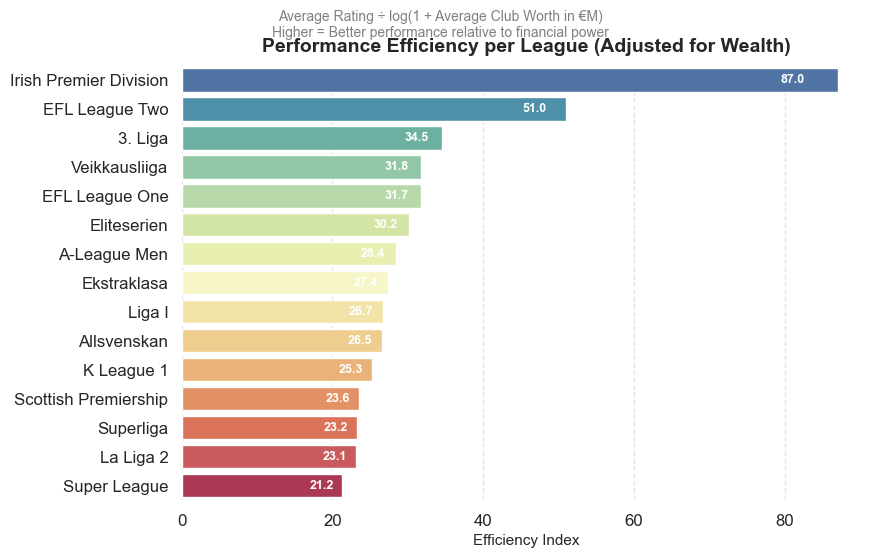

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Compute league performance ---
league_perf = (
    clubs.groupby("league")[["rating", "club_worth_million"]]
    .mean()
    .reset_index()
)

# --- Efficiency formula: adjusted for wealth using log(1 + worth) ---
league_perf = league_perf[league_perf["club_worth_million"] > 0].copy()
league_perf["efficiency"] = league_perf["rating"] / np.log1p(league_perf["club_worth_million"])

# --- Sort top leagues ---
league_eff = league_perf.sort_values("efficiency", ascending=False).head(15)

# --- Reset index for clean plotting ---
league_eff = league_eff.reset_index(drop=True)

# --- Palette ---
palette = sns.color_palette("Spectral_r", n_colors=len(league_eff))

# --- Create figure ---
plt.figure(figsize=(9, 6))
ax = sns.barplot(
    data=league_eff,
    y="league",
    x="efficiency",
    palette=palette
)

# --- Add text labels (inside bars or to the right if too small) ---
for i, (eff, league) in enumerate(zip(league_eff["efficiency"], league_eff["league"])):
    if eff > league_eff["efficiency"].max() * 0.15:
        # If bar is wide enough → white text inside bar
        ax.text(eff - (eff * 0.05), i, f"{eff:.1f}", color="white", va="center", ha="right", fontsize=9, weight="bold")
    else:
        # Otherwise → black text outside
        ax.text(eff + 0.5, i, f"{eff:.1f}", color="black", va="center", ha="left", fontsize=9)

# --- Titles and labels ---
plt.title(
    "Performance Efficiency per League (Adjusted for Wealth)",
    fontsize=14, weight="bold", pad=10
)
plt.suptitle(
    "Average Rating ÷ log(1 + Average Club Worth in €M)\nHigher = Better performance relative to financial power",
    fontsize=10, color="gray", y=0.93
)
plt.xlabel("Efficiency Index", fontsize=11)
plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.5)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


In [8]:
country_perf = (
    clubs.groupby("country")
    .agg(
        avg_rating=("rating", "mean"),
        avg_budget=("club_worth_million", "mean"),
        n_clubs=("name", "count"),
        top_clubs=("name", lambda x: ", ".join(x.head(3)))
    )
    .reset_index()
)


In [9]:
import plotly.express as px

fig = px.choropleth(
    country_perf,
    locations="country",
    locationmode="country names",  # you can also use ISO codes if you have them
    color="avg_budget",
    color_continuous_scale="Viridis",
    hover_name="country",
    hover_data={
        "avg_budget": True,
        "avg_rating": True,
        "n_clubs": True,
        "top_clubs": True
    },
    title="Average Club Budget per Country (SoFIFA Data)"
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type="natural earth"
    ),
    coloraxis_colorbar=dict(title="Avg Budget (€M)")
)

fig.show()


In [18]:
# 🌍 Country-specific league normalization (ensure before export)
# - India: 'Super League' -> 'Indian Super League'
# - Greece: 'Super League' -> 'Greek Super League'
# - Saudi Arabia: 'Pro League' -> 'Saudi Pro League'
# - Belgium: 'Pro League' -> 'Belgian Pro League'
# - UAE: 'Pro League' -> 'UAE Pro League'

if all(col in clubs.columns for col in ["country", "league"]):
    # Normalize case/whitespace once
    ctry = clubs["country"].astype(str).str.strip()
    lg = clubs["league"].astype(str).str.strip()

    # India renaming
    mask_india = ctry.str.lower().eq("india") & lg.str.lower().eq("super league")
    n_ind = int(mask_india.sum())
    if n_ind:
        clubs.loc[mask_india, "league"] = "Indian Super League"
        print(f"✔ Renamed {n_ind} rows to 'Indian Super League'.")

    # Greece renaming
    mask_greece = ctry.str.lower().eq("greece") & lg.str.lower().eq("super league")
    n_gr = int(mask_greece.sum())
    if n_gr:
        clubs.loc[mask_greece, "league"] = "Greek Super League"
        print(f"✔ Renamed {n_gr} rows to 'Greek Super League'.")

    # Country-aware 'Pro League'
    is_pro_league = lg.str.lower().eq("pro league")
    # Saudi
    m_sa = ctry.str.lower().eq("saudi arabia") & is_pro_league
    n_sa = int(m_sa.sum())
    if n_sa:
        clubs.loc[m_sa, "league"] = "Saudi Pro League"
        print(f"✔ Renamed {n_sa} rows to 'Saudi Pro League'.")
    # Belgium
    m_be = ctry.str.lower().eq("belgium") & is_pro_league
    n_be = int(m_be.sum())
    if n_be:
        clubs.loc[m_be, "league"] = "Belgian Pro League"
        print(f"✔ Renamed {n_be} rows to 'Belgian Pro League'.")
    # UAE
    m_uae = ctry.str.lower().isin(["uae", "united arab emirates"]) & is_pro_league
    n_uae = int(m_uae.sum())
    if n_uae:
        clubs.loc[m_uae, "league"] = "UAE Pro League"
        print(f"✔ Renamed {n_uae} rows to 'UAE Pro League'.")
else:
    print("⚠️ Missing 'country' or 'league' columns; cannot normalize country-specific leagues.")

✔ Renamed 14 rows to 'Indian Super League'.
✔ Renamed 4 rows to 'Greek Super League'.
✔ Renamed 18 rows to 'Saudi Pro League'.
✔ Renamed 16 rows to 'Belgian Pro League'.
✔ Renamed 1 rows to 'UAE Pro League'.


In [19]:
# ✅ Produce a descriptive-only clubs CSV for merging with Transfermarkt
# 1) Columns we prefer (prefer these names if present; we'll map fallbacks)
preferred_cols = {
    'club_name': 'club',
    'name': 'club',
    'club': 'club',

    'league': 'league_name',
    'league_name': 'league_name',

    'country': 'country_name',
    'country_name': 'country_name',

    'average_rating': 'average_rating',
    'overall': 'average_rating',
    'rating': 'average_rating',

    'number_of_players': 'squad_size',
    'squad_size': 'squad_size',
    'squad': 'squad_size',

    'coach_name': 'coach_name',
    'manager': 'coach_name',
    'manager_name': 'coach_name',

    'stadium_name': 'stadium_name',
    'stadium': 'stadium_name'
}

# 2) Build the list of available source columns and their target names
available_map = {src: tgt for src, tgt in preferred_cols.items() if src in clubs.columns}
# Ensure we always have at least club, league, country
required_targets = ['club', 'league_name', 'country_name']

# 3) Create the cleaned DataFrame with selected columns
selected_columns = list(available_map.keys())
clean = clubs[selected_columns].rename(columns=available_map).copy()

# 4) Drop game-only / redundant columns if present (explicit list)
drop_like = [
    'club_worth_million', 'club_value_game', 'transfer_budget', 'popularity_index',
    'wage', 'value', 'financials', 'market_value', 'average_rating_x', 'average_rating_y'
]
for col in drop_like:
    if col in clean.columns:
        clean = clean.drop(columns=[col])

# 5) Keep only the canonical set (if columns missing we'll produce what we have)
canonical = ['club', 'league_name', 'country_name', 'average_rating', 'squad_size', 'coach_name', 'stadium_name']
final_cols = [c for c in canonical if c in clean.columns]
clean = clean[final_cols]

# 6) Quick safety checks
if not all(rt in clean.columns for rt in required_targets):
    missing = [rt for rt in required_targets if rt not in clean.columns]
    raise ValueError(f"Missing required columns after cleaning: {missing}")

# 7) Save
output_path = "../Scrapping/Data/Clubs/sofifa_clubs_clean.csv"
clean.to_csv(output_path, index=False, encoding='utf-8')
print(f"Saved descriptive clubs CSV to: {output_path} (rows={len(clean)}, columns={clean.columns.tolist()})")


Saved descriptive clubs CSV to: ../Scrapping/Data/Clubs/sofifa_clubs_clean.csv (rows=662, columns=['club', 'league_name', 'country_name', 'average_rating', 'coach_name', 'stadium_name'])


In [12]:
# 🛠 Fix numeric club names (India bug): if club 'name' is digits, try to recover from URL
import re

def recover_name_from_url(url: str) -> str | None:
    if not isinstance(url, str):
        return None
    m = re.search(r"/team/\d+/([^/]+)/?", url)
    if m:
        slug = m.group(1)
        # turn slug like "mohun-bagan" → "Mohun Bagan"
        return re.sub(r"[-_]+", " ", slug).title()
    return None

mask_numeric = clubs["name"].astype(str).str.fullmatch(r"\d+")
if mask_numeric.any():
    print(f"Repairing {mask_numeric.sum()} numeric club names using URL slugs...")
    # Load the URL column if it exists; else skip with warning
    if "url" in clubs.columns:
        repaired = clubs.loc[mask_numeric, "url"].apply(recover_name_from_url)
        clubs.loc[mask_numeric, "name"] = clubs.loc[mask_numeric, "name"].mask(repaired.notna(), repaired)
    else:
        print("Warning: 'url' column not available; cannot repair numeric names.")

# Re-save the descriptive-only CSV downstream cell will write


Repairing 1 numeric club names using URL slugs...
